# LangGraph Deep Dive: From Theory to Implementation

## Overview

이 튜토리얼은 LangGraph의 핵심 개념과 실제 구현 방법을 다룹니다. LangGraph는 LLM 기반 애플리케이션을 상태 머신으로 구조화하여 구축할 수 있는 고급 프레임워크입니다.

주요목표: StageGraph 구성하기

### Prerequisites
- Python 3.9+
- OpenAI API Key
- LangChain 기본 지식

## Table of Contents
1. [LangGraph vs LangChain](#1-langgraph-vs-langchain)
2. [Core Concepts](#2-core-concepts)
3. [StateGraph 실습](#3-implementation)

---

## 1. LangGraph vs LangChain

## LangGraph vs LangChain 비교

LangGraph는 그래프 기반 아키텍처로 AI 워크플로우를 구축하는 프레임워크로, 명시적인 상태 관리와 세밀한 제어 흐름을 제공합니다. 복잡한 다중 에이전트 시스템과 상태 기반 워크플로우를 모듈화하여 효율적으로 구현할 수 있게 해줍니다.

| 특성 | LangGraph | LangChain |
|------|-----------|------------|
| **아키텍처** | 그래프 기반 (DAG) | 체인 기반 (선형) |
| **상태 관리** | 명시적 (Explicit) | 암시적 (Implicit) |
| **유스케이스** | 복잡한 워크플로우, 다중 에이전트 시스템 | 단순 체인, RAG 구현 |
| **제어 흐름** | 세밀한 제어 가능 (Fine-grained) | 제한된 제어 (Limited) |
| **디버깅** | 상태 추적 용이 | 블랙박스적 특성 |

## 핵심 기능

1. **상태 기반 그래프 구조**: 애플리케이션의 로직을 노드와 엣지로 구성된 그래프로 표현합니다.

2. **유연한 상태 관리**: 복잡한 상태를 쉽게 정의하고 관리할 수 있습니다.

3. **조건부 라우팅**: 동적인 의사결정 프로세스를 구현할 수 있습니다.

4. **체크포인팅**: 그래프 실행 상태를 저장하고 복원할 수 있어 장기 실행 태스크와 오류 복구에 유용합니다.

5. **서브그래프 지원**: 복잡한 시스템을 모듈화하여 관리할 수 있습니다.


---
## 2. Core Concepts

LangGraph의 핵심 구성요소는 다음과 같습니다:

### 2.1 State

| 개념 | 설명 | 특징 |
|------|------|------|
| **정의** | 그래프 실행 중 공유되는 상태 객체 | TypedDict 또는 Pydantic Model |
| **역할** | 노드 간 데이터 공유 및 컨텍스트 유지 | Immutable 업데이트 |
| **구조** | Key-Value 페어의 집합 | Type Hints 필수 |

### 2.2 Nodes

| 개념 | 설명 | 특징 |
|------|------|------|
| **정의** | 실제 작업을 수행하는 함수 | Pure Function 형태 |
| **입력** | Current State | State 타입의 파라미터 |
| **출력** | Updated State | State의 부분 업데이트 |
| **특성** | Side-effect free | 멱등성(Idempotent) 보장 |

### 2.3 Edges

| 개념 | 설명 | 특징 |
|------|------|------|
| **정의** | 노드 간 연결 및 전이 규칙 | 방향성 있는 연결 |
| **역할** | 실행 흐름 제어 | 조건부 라우팅 가능 |
| **타입** | Normal, Conditional | 상태에 따른 분기 처리 |

### 2.4 StateGraph

| 개념 | 설명 | 특징 |
|------|------|------|
| **정의** | 전체 워크플로우를 표현하는 그래프 | DAG 구조 |
| **생명주기** | 초기화 → 실행 → 종료 | Superstep 기반 실행 |
| **특성** | Deterministic 실행 | 재현 가능한 결과 |

---
## 3. Implementation

이제 실제 구현을 통해 위 개념들을 적용해보겠습니다.

### 3.1 Environment Setup

필요한 패키지를 설치하고 환경을 구성합니다.

In [1]:
# 필요한 패키지 임포트
from typing import Annotated, TypedDict, List
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_openai import ChatOpenAI
import os
import dotenv

# 환경변수 로드
dotenv.load_dotenv(".env")
if "OPENAI_API_KEY" not in os.environ:
    raise EnvironmentError("OPENAI_API_KEY must be set in .env file")

### 3.2 State Definition

상태 객체를 정의합니다. 여기서는 메시지 이력을 관리하는 간단한 상태를 구현합니다.

- `TypedDict`를 사용하여 타입 안정성 확보
- `Annotated`를 통한 메타데이터 추가
- `add_messages` 어노테이션으로 메시지 누적 로직 자동화

In [2]:
class State(TypedDict):
    """애플리케이션의 상태를 정의하는 클래스
    
    Attributes:
        messages (List): 대화 이력을 저장하는 리스트
            - add_messages 어노테이션을 통해 자동 메시지 누적
            - 불변성(immutability) 보장을 위해 리스트 복사본 사용
    """
    messages: Annotated[List, add_messages]

### 3.3 Node Implementation

상태를 처리하는 노드 함수를 구현합니다. 여기서는 간단한 챗봇 노드를 예시로 들겠습니다.

In [3]:
# LLM 인스턴스 생성
llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0,   # 0~2
)

def chatbot(state: State) -> dict:
    """챗봇 노드 함수
    
    Args:
        state (State): 현재 애플리케이션 상태
        
    Returns:
        dict: 업데이트된 상태의 일부 (부분 업데이트)
        
    Note:
        - Pure function: 외부 상태 변경 없음
        - Immutable: 입력 상태 직접 수정하지 않음
        - Deterministic: 동일 입력 → 동일 출력
    """
    # LLM 호출 및 응답 생성
    response = llm.invoke(state["messages"])
    
    # 부분 상태 업데이트 반환
    return {"messages": [response]}

### 3.4 Graph Construction

노드들을 연결하여 전체 그래프를 구성합니다.

In [4]:
# StateGraph 인스턴스 생성
workflow = StateGraph(State)

# 노드 추가
workflow.add_node("chatbot", chatbot)

# 엣지 설정
workflow.set_entry_point("chatbot")
workflow.add_edge("chatbot", END)

# 그래프 컴파일
app = workflow.compile()

### 3.5 Visualization

구성된 그래프를 시각화하여 워크플로우를 검증합니다.

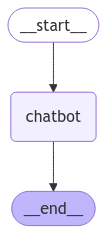

In [5]:
from IPython.display import Image, display

# Mermaid 형식으로 그래프 시각화
print(workflow) # StateGraph
print(app) # CompiledStateGraph 
display(Image(app.get_graph().draw_mermaid_png()))

위처럼, **\_\_SRART\_\_** , 로 시작하고, `chatbot`노드가 존재하고, **\_\_END\_\_** 로 종료되는 하나의 StateGraph가 생성 및 컴파일된것을 확인할 수 있습니다.


### 3.6 그래프 실행


이제, compile된 그래프는 Runnable Interface이므로, invoke, stream 등이 가능합니다.


In [6]:
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_core.runnables.config import RunnableConfig

# LangChain의 message 클래스 사용
result = app.invoke({
    "messages": [
        SystemMessage(content="당신은 유용한 챗봇입니다."),
        HumanMessage(content="안녕?")
    ]},
    RunnableConfig(),
    debug=True
)

[-1:checkpoint] State at the end of step -1:
{'messages': []}
[0:tasks] Starting 1 task for step 0:
- __start__ -> {'messages': [SystemMessage(content='당신은 유용한 챗봇입니다.', additional_kwargs={}, response_metadata={}),
              HumanMessage(content='안녕?', additional_kwargs={}, response_metadata={})]}
[0:writes] Finished step 0 with writes to 1 channel:
- messages -> [SystemMessage(content='당신은 유용한 챗봇입니다.', additional_kwargs={}, response_metadata={}),
 HumanMessage(content='안녕?', additional_kwargs={}, response_metadata={})]
[0:checkpoint] State at the end of step 0:
{'messages': [SystemMessage(content='당신은 유용한 챗봇입니다.', additional_kwargs={}, response_metadata={}, id='9183fcc3-70b3-4d44-a767-b3bfaddc1393'),
              HumanMessage(content='안녕?', additional_kwargs={}, response_metadata={}, id='d55966fe-763b-4897-bb39-04da0a364862')]}
[1:tasks] Starting 1 task for step 1:
- chatbot -> {'messages': [SystemMessage(content='당신은 유용한 챗봇입니다.', additional_kwargs={}, response_metadata={}, id='91

> 지금까지는, 상당히 단순한 직렬적인 Graph를 예시로 구성하였습니다. 이제 하나의 Tool을 설정해보겠습니다.
또한, add_messages메서드로 인해 state의 messages가 추가되는것을 확인할 수 있습니다.

---